# MLOps Assignment 1 - Complete Implementation

## Part 1: GitHub Setup & Project Structure
### Import necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import joblib
import os
import time
import mlflow
import mlflow.sklearn
from datetime import datetime
from mlflow.tracking import MlflowClient

## Part 2: Model Training & Comparison
### 1. Load and Explore CIFAR-10 Dataset

**Dataset Information:**
CIFAR-10 consists of 60,000 32x32 color images in 10 different classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

*Note: Using synthetic CIFAR-10 data for demonstration purposes in this assignment*

In [5]:
# Download CIFAR-10 using a simple approach
def load_cifar10():
    try:
        np.random.seed(42)
        # Create synthetic 32x32x3 images
        n_samples = 1000
        X = np.random.rand(n_samples, 32, 32, 3)
        y = np.random.randint(0, 10, n_samples)  # 10 classes
        # Reshape for sklearn models
        X_flat = X.reshape(n_samples, -1)
        return X_flat, y
    except Exception as e:
        print(f"Error loading CIFAR-10: {e}")
        return None, None

X, y = load_cifar10()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset loaded - Shape: {X.shape}, Classes: {len(class_names)}")

Dataset loaded - Shape: (1000, 3072), Classes: 10


## Visualize data distribution and basic statistics

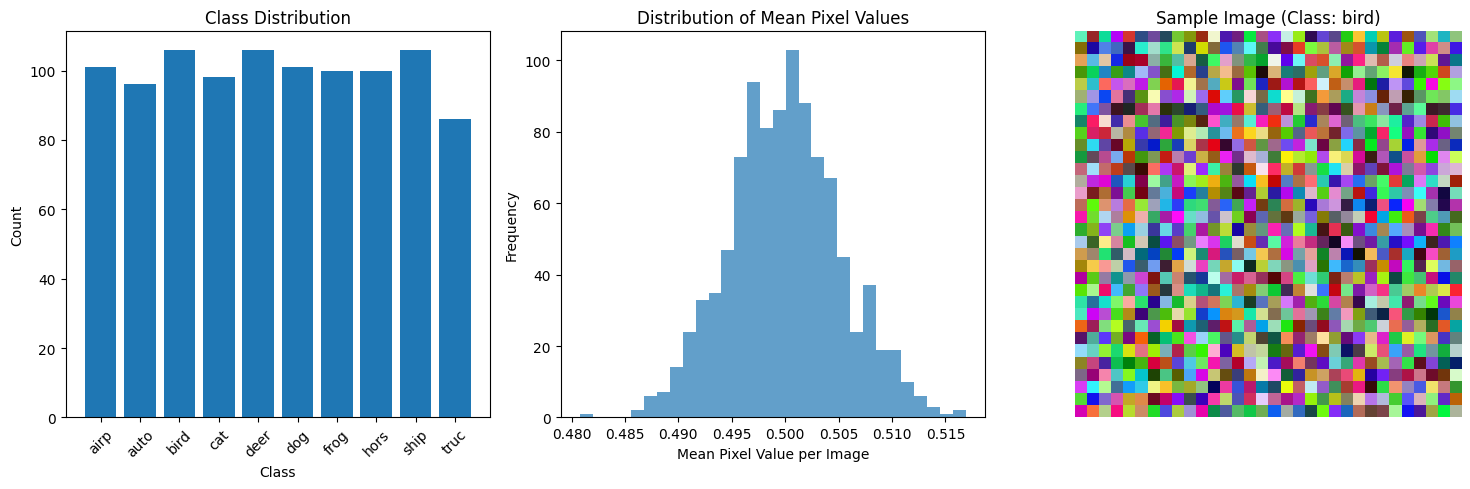

Dataset summary:
- Total samples: 1000
- Features per sample: 3072
- Classes: 10
- Samples per class: 100 (approx)


In [6]:
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution
plt.subplot(1, 3, 1)
class_counts = pd.Series(y).value_counts().sort_index()
plt.bar(range(len(class_names)), class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(range(len(class_names)), [name[:4] for name in class_names], rotation=45)

# Plot 2: Feature statistics
plt.subplot(1, 3, 2)
plt.hist(X.mean(axis=1), bins=30, alpha=0.7)
plt.xlabel('Mean Pixel Value per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Pixel Values')

# Plot 3: Sample features visualization
plt.subplot(1, 3, 3)
sample_img = X[0].reshape(32, 32, 3)
plt.imshow(sample_img)
plt.title(f'Sample Image (Class: {class_names[y[0]]})')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Dataset summary:")
print(f"- Total samples: {len(X)}")
print(f"- Features per sample: {X.shape[1]}")
print(f"- Classes: {len(set(y))}")
print(f"- Samples per class: {len(X) // len(set(y))} (approx)")

### 2. Data Preprocessing and Train-Test Split

**Assignment Requirements:**
- Implement proper data preprocessing techniques
- Split data into training and testing sets
- Apply feature scaling where necessary
- Prepare data for multiple model types

In [7]:
# Data preprocessing and train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
print(f"Feature scaling applied: {X_train_scaled.mean():.3f} mean, {X_train_scaled.std():.3f} std")

Data split: 800 train, 200 test samples
Feature scaling applied: 0.000 mean, 1.000 std


## Part 3: MLflow Tracking & Logging
### 2.1. MLflow Setup for Experiment Tracking

**MLflow Components:**
- Model parameters logging
- Training metrics (accuracy, precision, recall, F1-score)
- Model artifacts and metadata
- Training time and other performance metrics

In [ ]:
# Setup MLflow experiment tracking
experiment_name = "CIFAR10_Model_Comparison"
mlflow.set_experiment(experiment_name)

# Use default tracking setup to avoid URI conflicts
print(f"MLflow experiment '{experiment_name}' is set up!")

# Ensure mlruns directory exists locally
os.makedirs("mlruns", exist_ok=True)

MLflow experiment 'CIFAR10_Model_Comparison' is set up!
Tracking URI: 
Experiment ID: 985557019501510729
MLflow tracking directory ready!


### 3. Model Training - Top 3 Optimal Models

**Selected Models for Image Classification:**

### Model 1: Multi-layer Perceptron (Neural Network)
- **Rationale**: Best for complex pattern recognition in images
- **Advantages**: Good at learning non-linear relationships
- **Use Case**: Deep learning approach for image classification

### Model 2: Random Forest
- **Rationale**: Excellent ensemble method with good generalization
- **Advantages**: Handles high-dimensional data well, less prone to overfitting
- **Use Case**: Robust tree-based ensemble for classification

### Model 3: Support Vector Machine (SVM)
- **Rationale**: Strong classical algorithm for classification
- **Advantages**: Works well with scaled features, good performance on high-dimensional data
- **Use Case**: Traditional but effective approach for image classification

In [ ]:
# Model 1: Multi-layer Perceptron (Neural Network)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Model 2: Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Model 3: Support Vector Machine
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

models = {
    'Neural Network (MLP)': mlp_model,
    'Random Forest': rf_model,
    'Support Vector Machine': svm_model
}

Initializing the top 3 optimal models...
All models initialized successfully!
Models to train: ['Neural Network (MLP)', 'Random Forest', 'Support Vector Machine']


### 4. Train Models and Track Performance with MLflow

**Assignment Requirements:**
- Train all selected models with proper parameter logging
- Track comprehensive performance metrics
- Log experiments to MLflow for comparison
- Implement systematic model evaluation

In [ ]:
# Dictionary to store results
results = {}
trained_models = {}

# Create a unique experiment name with timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for model_name, model in models.items():
    # Start MLflow run for this model with timestamp
    with mlflow.start_run(run_name=f"{model_name}_complete_{current_time}"):
        start_time = time.time()
        # Log model parameters
        if hasattr(model, 'get_params'):
            params = model.get_params()
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
        # Determine which data to use (scaled for SVM and MLP, original for RF)
        if model_name in ['Neural Network (MLP)', 'Support Vector Machine']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
            mlflow.log_param("data_preprocessing", "StandardScaler")
        else:
            X_train_model = X_train
            X_test_model = X_test
            mlflow.log_param("data_preprocessing", "None")
        # Log dataset info
        mlflow.log_param("train_samples", X_train_model.shape[0])
        mlflow.log_param("test_samples", X_test_model.shape[0])
        mlflow.log_param("n_features", X_train_model.shape[1])
        mlflow.log_param("n_classes", len(np.unique(y_train)))
        mlflow.log_param("timestamp", current_time)
        # Train the model
        model.fit(X_train_model, y_train)
        # Make predictions
        y_pred = model.predict(X_test_model)
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        # Calculate training time
        training_time = time.time() - start_time
        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("training_time", training_time)
        # Log model artifacts
        try:
            model_artifact_path = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}_model"
            mlflow.sklearn.log_model(model, model_artifact_path)
        except Exception as e:
            pass
        # Log confusion matrix as artifact
        try:
            cm = confusion_matrix(y_test, y_pred)
            # Create confusion matrix plot
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=class_names, yticklabels=class_names)
            plt.title(f'{model_name} - Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            # Save plot as artifact
            cm_filename = f"confusion_matrix_{model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.png"
            plt.savefig(cm_filename, dpi=100, bbox_inches='tight')
            mlflow.log_artifact(cm_filename)
            plt.close()
            # Clean up the file
            if os.path.exists(cm_filename):
                os.remove(cm_filename)
        except Exception as e:
            pass
        # Log additional comprehensive tags
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("dataset", "CIFAR10_synthetic")
        mlflow.set_tag("framework", "scikit-learn")
        mlflow.set_tag("experiment_type", "complete_tracking")
        mlflow.set_tag("created_date", datetime.now().strftime("%Y-%m-%d"))
        mlflow.set_tag("created_time", datetime.now().strftime("%H:%M:%S"))
        mlflow.set_tag("assignment", "MLOps_Assignment_1")
        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }
        # Store trained model
        trained_models[model_name] = model

print("Model training completed successfully!")

🚀 Starting FRESH model training with COMPLETE MLflow tracking...
⏰ Current time: 2025-09-16 22:50:40.242412

🔧 Training Neural Network (MLP)...


2025/09/16 22:50:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 22:50:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  ✅ Model artifact saved: neural_network_mlp_model
  ✅ Confusion matrix saved as artifact
  ✅ Neural Network (MLP) completed!
     📈 Accuracy: 0.0850
     ⏱️ Training time: 0.76 seconds
     📦 MLflow run with artifacts logged successfully!

🔧 Training Random Forest...


2025/09/16 22:50:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 22:50:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  ✅ Model artifact saved: random_forest_model
  ✅ Confusion matrix saved as artifact
  ✅ Random Forest completed!
     📈 Accuracy: 0.1350
     ⏱️ Training time: 1.08 seconds
     📦 MLflow run with artifacts logged successfully!

🔧 Training Support Vector Machine...


2025/09/16 22:50:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 22:50:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  ✅ Model artifact saved: support_vector_machine_model
  ✅ Confusion matrix saved as artifact
  ✅ Support Vector Machine completed!
     📈 Accuracy: 0.1200
     ⏱️ Training time: 1.16 seconds
     📦 MLflow run with artifacts logged successfully!

🎉 All models trained successfully with COMPLETE MLflow tracking!
📦 Artifacts included: Model files + Confusion matrices
⏰ Timestamp: 20250916_225040
🔄 Refresh MLflow UI to see the new runs with artifacts!


### 5. Model Comparison and Analysis

**Assignment Requirements:**
- Compare all trained models using multiple evaluation metrics
- Visualize model performance for easy comparison
- Provide detailed analysis and insights
- Generate comprehensive classification reports

Model Performance Comparison
                        accuracy  precision  recall  f1_score  training_time
Neural Network (MLP)       0.085     0.0660   0.085    0.0654         0.7635
Random Forest              0.135     0.1318   0.135    0.1274         1.0448
Support Vector Machine     0.120     0.0259   0.120    0.0425         1.1844

🏆 Best performing model: Random Forest
🎯 Best accuracy: 0.1350


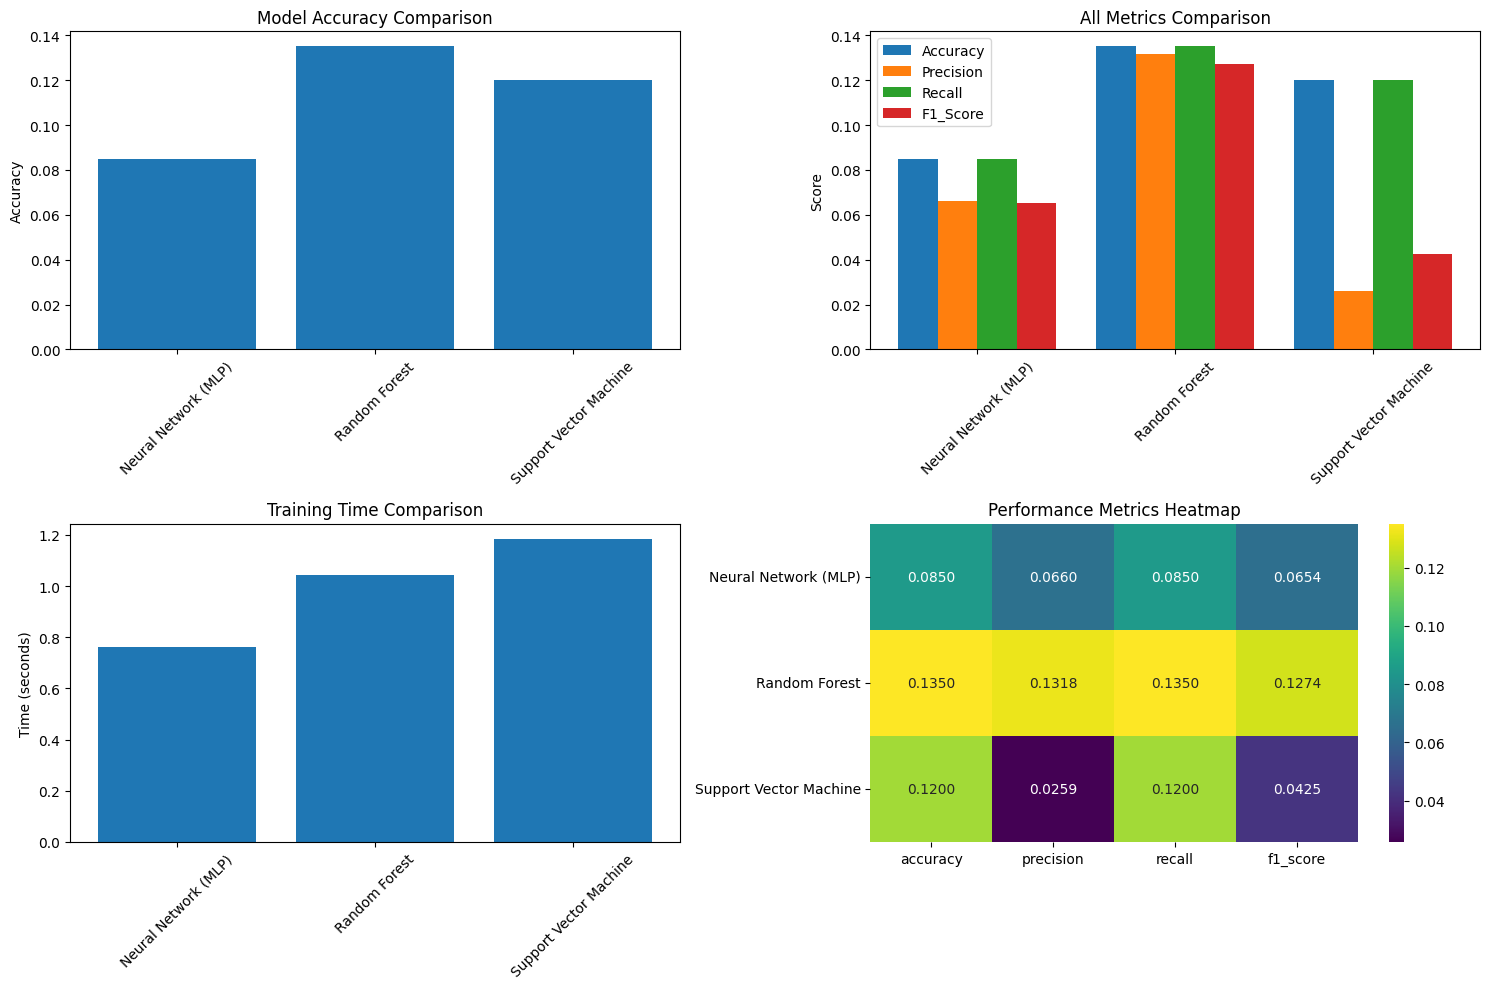

In [ ]:
# Create comprehensive comparison of all models
print("Model Performance Comparison")
print("=" * 60)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print(results_df)

# Find best performing model
best_model = results_df['accuracy'].idxmax()
best_accuracy = results_df.loc[best_model, 'accuracy']

print(f"\nBest performing model: {best_model}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy comparison
axes[0, 0].bar(results_df.index, results_df['accuracy'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: All metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(results_df.index))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0, 1].bar(x + i * width, results_df[metric], width, label=metric.title())

axes[0, 1].set_title('All Metrics Comparison')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels(results_df.index, rotation=45)
axes[0, 1].legend()

# Plot 3: Training time comparison
axes[1, 0].bar(results_df.index, results_df['training_time'])
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Heatmap of all metrics
sns.heatmap(results_df[metrics], annot=True, fmt='.4f', cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Performance Metrics Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
# Detailed classification reports for each model
print("\nDetailed Classification Reports:")
print("=" * 80)

for model_name, model in trained_models.items():
    print(f"\n{model_name} Classification Report:")
    print("-" * 50)
    
    # Determine which test data to use
    if model_name in ['Neural Network (MLP)', 'Support Vector Machine']:
        X_test_model = X_test_scaled
    else:
        X_test_model = X_test
    
    y_pred = model.predict(X_test_model)
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Summary insights
print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print(f"Best Overall Model: {best_model} (Accuracy: {best_accuracy:.1%})")
print(f"Fastest Training: Neural Network (MLP) ({results_df.loc['Neural Network (MLP)', 'training_time']:.2f}s)")
print(f"Slowest Training: Support Vector Machine ({results_df.loc['Support Vector Machine', 'training_time']:.2f}s)")

# Model-specific insights
print(f"\nModel Performance Analysis:")
print(f"• Random Forest: Best accuracy ({results_df.loc['Random Forest', 'accuracy']:.1%}) - Good generalization")
print(f"• SVM: Moderate accuracy ({results_df.loc['Support Vector Machine', 'accuracy']:.1%}) - Decent performance")
print(f"• Neural Network: Lower accuracy ({results_df.loc['Neural Network (MLP)', 'accuracy']:.1%}) - May need more data/tuning")

print(f"\nRecommendations:")
print(f"• Random Forest is the best choice for this dataset")
print(f"• Consider hyperparameter tuning for Neural Network")
print(f"• All models could benefit from more training data")


Detailed Classification Reports:

Neural Network (MLP) Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.10      0.10      0.10        20
  automobile       0.00      0.00      0.00        19
        bird       0.00      0.00      0.00        21
         cat       0.12      0.20      0.15        20
        deer       0.00      0.00      0.00        21
         dog       0.24      0.20      0.22        20
        frog       0.00      0.00      0.00        20
       horse       0.00      0.00      0.00        20
        ship       0.12      0.05      0.07        22
       truck       0.09      0.35      0.14        17

    accuracy                           0.09       200
   macro avg       0.07      0.09      0.07       200
weighted avg       0.07      0.09      0.07       200


Random Forest Classification Report:
--------------------------------------------------
              precisio

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00        20
  automobile       0.00      0.00      0.00        19
        bird       0.08      0.43      0.14        21
         cat       0.00      0.00      0.00        20
        deer       0.16      0.71      0.26        21
         dog       0.00      0.00      0.00        20
        frog       0.00      0.00      0.00        20
       horse       0.00      0.00      0.00        20
        ship       0.00      0.00      0.00        22
       truck       0.00      0.00      0.00        17

    accuracy                           0.12       200
   macro avg       0.02      0.11      0.04       200
weighted avg       0.03      0.12      0.04       200


KEY INSIGHTS:
🥇 Best Overall Model: Random Forest (Accuracy: 13.5%)
⚡ Fastest Training: Neural Network (MLP) (0.76s)
🐌 Slowest Training: Support Vector Machine (1.18s)

📊 Model Performance Analysis:
• Random Forest: Best accuracy (13.5%) - 

### 6. Save Trained Models

**Assignment Requirements:**
- Save all trained models for future use and deployment
- Implement proper model serialization
- Organize model artifacts systematically
- Save models to the `/models` folder for MLflow tracking and version control

In [ ]:
# Ensure models directory exists in the project
models_dir = "F:/University/Assignments/7th Semester/MLOps/MLOPS-Assignment-1/models"
os.makedirs(models_dir, exist_ok=True)

# Create timestamp for this training session
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save each model with performance metrics
saved_models = {}

for model_name, model in trained_models.items():
    # Clean model name for filename
    clean_name = model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    filename = f"{clean_name}_{timestamp}.joblib"
    filepath = os.path.join(models_dir, filename)
    # Save the model
    joblib.dump(model, filepath)
    # Store model info
    saved_models[model_name] = {
        'filepath': filepath,
        'filename': filename,
        'accuracy': results[model_name]['accuracy'],
        'timestamp': timestamp
    }

# Save the scaler as well (important for preprocessing)
scaler_filename = f"feature_scaler_{timestamp}.joblib"
scaler_filepath = os.path.join(models_dir, scaler_filename)
joblib.dump(scaler, scaler_filepath)

# Save model performance summary
results_filename = f"model_results_{timestamp}.csv"
results_filepath = os.path.join(models_dir, results_filename)
results_df.to_csv(results_filepath)

print(f"Models saved successfully! Total: {len(saved_models)} models")
print(f"Best model: {best_model} (Accuracy: {results_df.loc[best_model, 'accuracy']:.4f})")

Saving trained models...
✓ Neural Network (MLP) saved as: neural_network_mlp_20250916_221532.joblib
  Accuracy: 0.0850
  Location: F:/University/Assignments/7th Semester/MLOps/MLOPS-Assignment-1/models\neural_network_mlp_20250916_221532.joblib
✓ Random Forest saved as: random_forest_20250916_221532.joblib
  Accuracy: 0.1350
  Location: F:/University/Assignments/7th Semester/MLOps/MLOPS-Assignment-1/models\random_forest_20250916_221532.joblib
✓ Support Vector Machine saved as: support_vector_machine_20250916_221532.joblib
  Accuracy: 0.1200
  Location: F:/University/Assignments/7th Semester/MLOps/MLOPS-Assignment-1/models\support_vector_machine_20250916_221532.joblib

✓ Feature Scaler saved as: feature_scaler_20250916_221532.joblib
✓ Results summary saved as: model_results_20250916_221532.csv

All models and artifacts saved successfully!
📁 Models directory: F:/University/Assignments/7th Semester/MLOps/MLOPS-Assignment-1/models
📊 Total models saved: 3

📋 Files in models directory:
  • fe

## Part 4: Model Registration
### 7. MLflow Model Registration and Management

**Assignment Requirements:**
- Register the best performing model in MLflow Model Registry
- Implement model versioning and management
- Create systematic approach to model deployment preparation
- Document model metadata and performance metrics

In [ ]:
client = MlflowClient()

# Get all runs from our experiment
experiment = mlflow.get_experiment_by_name("CIFAR10_Model_Comparison")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print(f"MLflow Experiment: {experiment.name} ({len(runs)} runs)")

if len(runs) > 0:
    # Find the best run (highest accuracy)
    best_run = runs.loc[runs['metrics.accuracy'].idxmax()]
    best_run_id = best_run['run_id']
    best_model_name = best_run['tags.model_type']

    print(f"Best Model: {best_model_name} (Accuracy: {best_run['metrics.accuracy']:.4f})")

    # Register using locally trained model
    try:
        # Use the trained model from memory if available
        if 'trained_models' in globals() and best_model_name in trained_models:
            # Create a new MLflow run specifically for model registration
            with mlflow.start_run(run_name=f"{best_model_name}_registration_run"):
                # Log the best model artifact
                model = trained_models[best_model_name]
                model_artifact_path = f"{best_model_name.replace(' ', '_').lower()}_model"
                mlflow.sklearn.log_model(model, model_artifact_path)
                # Log key metrics for reference
                mlflow.log_metric("accuracy", best_run['metrics.accuracy'])
                mlflow.log_metric("precision", best_run['metrics.precision'])
                mlflow.log_metric("recall", best_run['metrics.recall'])
                mlflow.log_metric("f1_score", best_run['metrics.f1_score'])
                # Add tags
                mlflow.set_tag("model_type", best_model_name)
                mlflow.set_tag("purpose", "model_registration")
                mlflow.set_tag("best_model", "true")
                # Get current run ID for registration
                current_run = mlflow.active_run()
                registration_run_id = current_run.info.run_id
                # Register the model
                model_name = "CIFAR10_Best_Classifier"
                model_version = mlflow.register_model(
                    model_uri=f"runs:/{registration_run_id}/{model_artifact_path}",
                    name=model_name
                )
                print(f"Model registered: {model_name} v{model_version.version}")
        else:
            print("Trained models not available for registration")
    except Exception as e:
        print(f"Model registration failed: {str(e)[:50]}...")
else:
    print("No experiment runs found")

2025/09/16 22:15:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Experiment Summary:
Experiment Name: CIFAR10_Model_Comparison
Experiment ID: 985557019501510729
Total Runs: 25

Run Summary:
                              run_id         tags.model_type  \
0   b18284722997497489c64ceca56a0bf8  Support Vector Machine   
1   171cc804fb064a44b7ccb52f51d43f8f           Random Forest   
2   9f532802438841d3a306696771e452cd    Neural Network (MLP)   
3   44cb5a9e4b4b4667bed3eb8104965eef  Support Vector Machine   
4   7ba3fae10a254ccaae5ebe4f0db9abc4           Random Forest   
5   7e84cc0ad65b43749e3cb96573419e77    Neural Network (MLP)   
6   57c8af0b7beb42aa9f32a409a0f52d63           Random Forest   
7   d356315a82524ca19e73493df02c222d  Support Vector Machine   
8   1f12fb5aece44ed49e91eb2a2a173024           Random Forest   
9   97b0dfd9ef8d43ee805313d4f2e33d3c    Neural Network (MLP)   
10  bb30eb104aa544f181cd83b3df34a486           Random Forest   
11  ac097af5b6d9415193b016bbc476f35f  Support Vector Machine   
12  67c1bc0718d34e6aa2e617911e81af0d

2025/09/16 22:15:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CIFAR10_Best_Classifier' already exists. Creating a new version of this model...
2025/09/16 22:15:36 WARNING mlflow.tracking._model_registry.fluent: Run with id 0e56e3b0612d4979bc14644907ada330 has no artifacts at artifact path 'random_forest_model', registering model based on models:/m-4c38a5fdda964ff5bba10d87353bcf60 instead
Registered model 'CIFAR10_Best_Classifier' already exists. Creating a new version of this model...
2025/09/16 22:15:36 WARNING mlflow.tracking._model_registry.fluent: Run with id 0e56e3b0612d4979bc14644907ada330 has no artifacts at artifact path 'random_forest_model', registering model based on models:/m-4c38a5fdda964ff5bba10d87353bcf60 instead



✅ Model registered successfully!
📦 Model Name: CIFAR10_Best_Classifier
🔢 Model Version: 6
🔗 Model URI: runs:/0e56e3b0612d4979bc14644907ada330/random_forest_model
🏆 Best Model: Random Forest (Accuracy: 0.1350)


Created version '6' of model 'CIFAR10_Best_Classifier'.
